# Reddit Vaccine Myths Analysis
Aim of the project is to analyze the vaccine myths on Reddit.

# DataSet
I have Downloaded this dataset from kaggle website. Here is the link: https://www.kaggle.com/gpreda/reddit-vaccine-myths

# What are we required to do
We have to analyze the vaccine myths on Reddit.

# Importing the Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import spacy
import re, string
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob 
from sklearn.decomposition import NMF 
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
df = pd.read_csv('reddit_vm.csv')

In [5]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1602 non-null   object 
 1   score      1602 non-null   int64  
 2   id         1602 non-null   object 
 3   url        469 non-null    object 
 4   comms_num  1602 non-null   int64  
 5   created    1602 non-null   float64
 6   body       1226 non-null   object 
 7   timestamp  1602 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 100.2+ KB


In [8]:
df.drop(columns=['id', 'url', 'created'], inplace=True)

In [9]:
df.head()

,title,score,comms_num,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,0,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,1,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,0,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,0,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,0,NaN,2021-02-16 11:36:28


In [10]:
df.head()

,title,score,comms_num,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,0,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,1,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,0,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,0,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,0,NaN,2021-02-16 11:36:28


# Explore Creation Date and Impact of Posts

In [11]:
sum(df['title'] == 'Comment')

1133

In [12]:
df.sort_values(by=['score'], ascending=False).head(10)

,title,score,comms_num,body,timestamp
512,I would rage if this was handed to me...,1187,595,NaN,2014-04-02 05:32:42
510,From /r/Rage,45,13,NaN,2014-04-02 23:01:49
212,Vaccines exposed,38,4,NaN,2020-12-18 05:11:12
291,Do not give a platform for anti-vaxxers to pro...,32,5,I am of the mind to report social media groups...,2019-02-12 01:04:08
465,Meet my friend's anti-vax wife,32,1,NaN,2014-04-29 22:47:41
276,Vaccines have a huge side effect,30,13,"Vaccines have a huge side effect, vaccines are...",2019-06-08 11:16:35
301,Oh no! I got vaccinated!,28,6,"\n\n\nAnd I'm completely fine, do some researc...",2018-11-21 20:35:02
238,How ironic,28,3,NaN,2020-03-06 11:19:39
246,Vaccinate folks.,27,7,NaN,2020-01-09 03:25:37
586,Why Trust Scientists?,26,1,NaN,2014-01-17 10:16:45


In [14]:
df['year'] = pd.DatetimeIndex(df['timestamp']).year
df['month'] = pd.DatetimeIndex(df['timestamp']).month

# Visualisation of Data

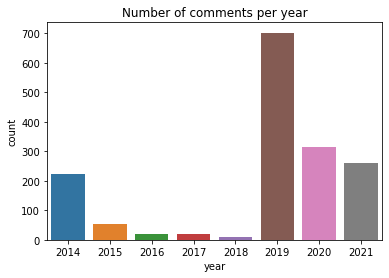

In [16]:
sns.countplot(x='year', data=df)
plt.title('Number of comments per year')
plt.show()

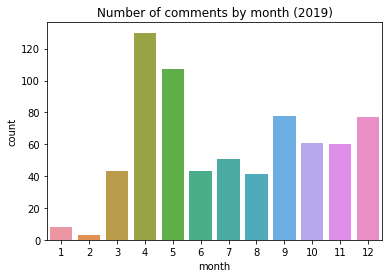

In [17]:
sns.countplot(x='month', data=df.loc[df['year'] == 2019])
plt.title('Number of comments by month (2019)')
plt.show()

# Text Preprocessing

In [22]:
def process(sentences):
    sentences = str(sentences)
    sentences = sentences.lower()
    chr = re.sub(r"[-()\"#/@;:<>\[\]{}`+=~|.!?,]", "", sentences)
    url = re.sub(r'http\S+', '', chr)
    url = re.sub(r'www\S+', '', url)
    nl = re.sub(r'\n', ' ', url)
    num = re.sub(r'[0-9]+', '', nl)
    space = re.sub(r'\s\s+', ' ', num)
    return space


In [23]:
nlp = spacy.load('en_core_web_sm')
STOP_WORDS.update(['vaccine', 'vaccination', 'vaccinate', 'vaccinated', 'use', 'people', 'person', 'like', 'think', 'know', 'case', 'want',
                   'mean', 'find', 'read', 'point'])

def lemmatize(sentences):
    # Create Doc object and disable components we don't need (for efficiency)
    doc = nlp(sentences, disable=['ner', 'parser'])

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    alp_lemmas = [lemma for lemma in lemmas 
                  if lemma.isalpha() and lemma not in STOP_WORDS] 

    return ' '.join(alp_lemmas)

In [25]:
df_cleaned = df.copy()

# Preprocess and lemmatize the title (non-comment) and body
df_cleaned.loc[df_cleaned['title'] != 'Comment', 'title'] = df_cleaned.loc[df_cleaned['title'] != 'Comment', 'title'].apply(process).apply(lemmatize)
df_cleaned.loc[~df_cleaned['body'].isnull(), 'body'] = df_cleaned.loc[~df_cleaned['body'].isnull(), 'body'].apply(process).apply(lemmatize)

In [26]:
df_cleaned.tail()

,title,score,comms_num,body,timestamp,year,month
1597,Comment,2,0,lol comprehension comprehensive look post thin...,2019-04-25 23:11:10,2019,4
1598,Comment,1,0,trouble thing trouble thing try I clever quip ...,2019-04-25 23:02:04,2019,4
1599,Comment,0,0,music play dance,2019-04-25 22:53:50,2019,4
1600,Comment,1,0,long ethyl mercury metabolize happen brain lon...,2019-04-25 22:35:39,2019,4
1601,Comment,1,0,sound I scrape barrel bounce erratically fully...,2019-04-25 22:21:34,2019,4


# Sentiment Analysis

In [30]:
df['sentiment'] = np.NaN
df['subjectivity'] = np.NaN

In [31]:
def basic_process(sentences):
    sentences = str(sentences)
    url = re.sub(r'http\S+', '', sentences)
    url = re.sub(r'www\S+', '', url)
    nl = re.sub(r'\n', ' ', url)
    space = re.sub(r'\s\s+', ' ', nl)
    return space

In [32]:
def getsentiment(sentences):
    if sentences != '':
      score = TextBlob(sentences).sentiment.polarity
      if score < 0:
          return "Negative"
      elif score == 0:
          return "Neutral"
      else:
          return "Positive"

In [33]:
def getsubjectivity(sentences):
    return TextBlob(sentences).sentiment.subjectivity

In [37]:
df.loc[~df['body'].isnull(), 'body'] = df.loc[~df['body'].isnull(), 'body'].apply(basic_process)

# Populate the sentiment and subjectivity
df.loc[~df['body'].isnull(), 'sentiment'] = df.loc[~df['body'].isnull(), 'body'].apply(getsentiment)
df.loc[~df['body'].isnull(), 'subjectivity'] = df.loc[~df['body'].isnull(), 'body'].apply(getsubjectivity)

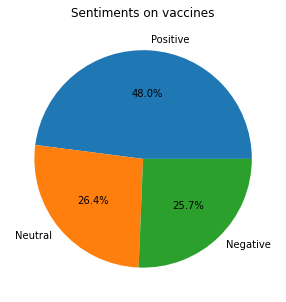

In [38]:
fig, ax = plt.subplots(figsize=(8,5))
ax.pie(df['sentiment'].value_counts(normalize=True), labels = ['Positive', 'Neutral', 'Negative'], autopct='%1.1f%%')
ax.set_title('Sentiments on vaccines')
plt.show();

In [40]:
df['subjectivity'].describe()

count    1226.000000
mean        0.401241
std         0.283161
min         0.000000
25%         0.168750
50%         0.439583
75%         0.583929
max         1.000000
Name: subjectivity, dtype: float64

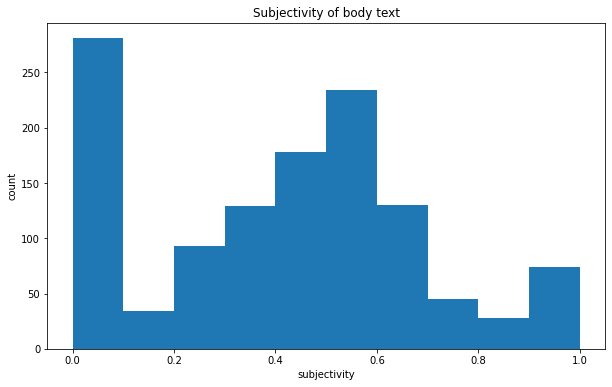

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(df['subjectivity'])
plt.title('Subjectivity of body text')
plt.xlabel('subjectivity')
plt.ylabel('count')
plt.show();

# Topic Modeling

In [42]:
def countwords(strings):
    words = strings.split()
    return len(words)

title = df_cleaned[df_cleaned['title'] != 'Comment'].copy()

title['title_word_count'] = title['title'].apply(countwords)

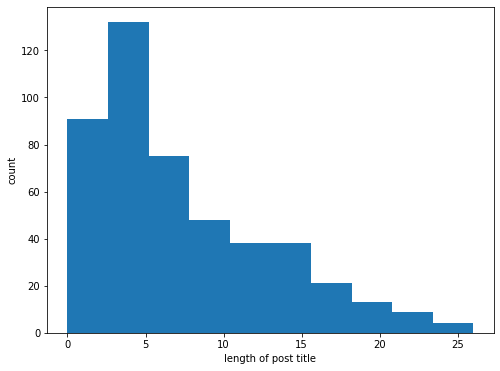

In [43]:
plt.figure(figsize=(8,6))
plt.hist(title['title_word_count'])
plt.xlabel('length of post title')
plt.ylabel('count')
plt.show();

# Conclusion:
- 2019 has the maximun number of comments.
- April month of 2019 has the maximun nnumber of commnets.
- Around half of the sentiments were positive, with another half split between neutral and negative.
- Highest length of post title is 120.